In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern
import scipy

RANDOM_STATE = np.random.RandomState(0)

In [2]:
kernel = Matern(length_scale=0.3, nu=5/2) #RBF(length_scale=0.3)
all_n_approx = [10, 100, 1000, 10000]

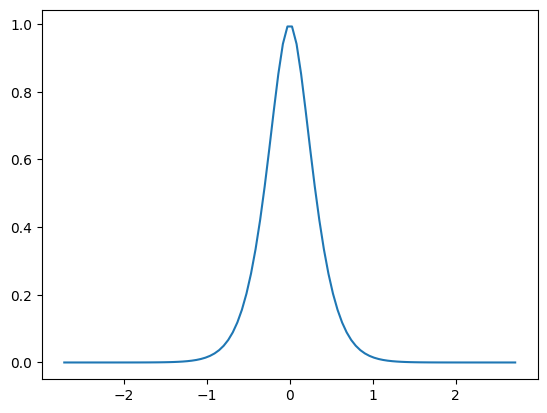

In [3]:

x_forplot = np.linspace(-np.e, np.e, 100)
plt.plot(x_forplot, kernel(x_forplot.reshape(-1, 1), np.zeros((1, 1))))

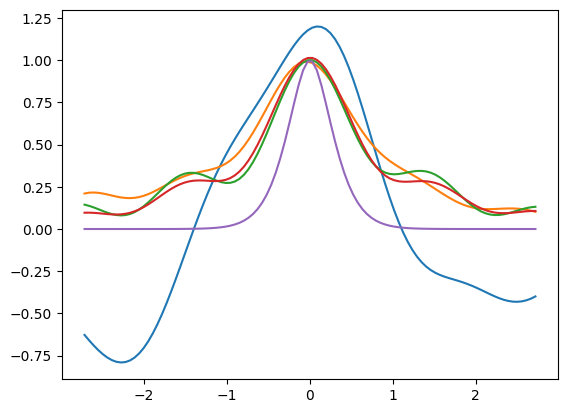

In [4]:
x_fft = np.linspace(0, 100, 1000)
dx = x_fft[1] - x_fft[0]
freqs = np.fft.rfftfreq(len(x_fft), dx)
spectral = np.abs(np.fft.rfft(kernel(x_fft.reshape(-1, 1), np.zeros((1, 1))).reshape(-1)))
alpha = np.sum(spectral)

def sample_w(size):
    return RANDOM_STATE.choice(freqs, size=size, p=spectral/np.sum(spectral))

def sample_b(size):
    return RANDOM_STATE.uniform(0, 2*np.pi, size=size)

def approx_kernel(x1, x2,  n=1000):
    x1, x2 = np.atleast_2d(x1, x2)
    w = np.expand_dims(sample_w(n), 0)
    b = np.expand_dims(sample_b(n), 0)
    q = np.cos(w.T @ x1 + b.T) * np.cos(w.T @ x2 + b.T)
    return 2 * np.mean(q, axis=0)

for n_approx in all_n_approx:
    plt.plot(x_forplot, approx_kernel(x_forplot, 0, n_approx))
plt.plot(x_forplot, kernel(x_forplot.reshape(-1, 1), np.zeros((1, 1))))

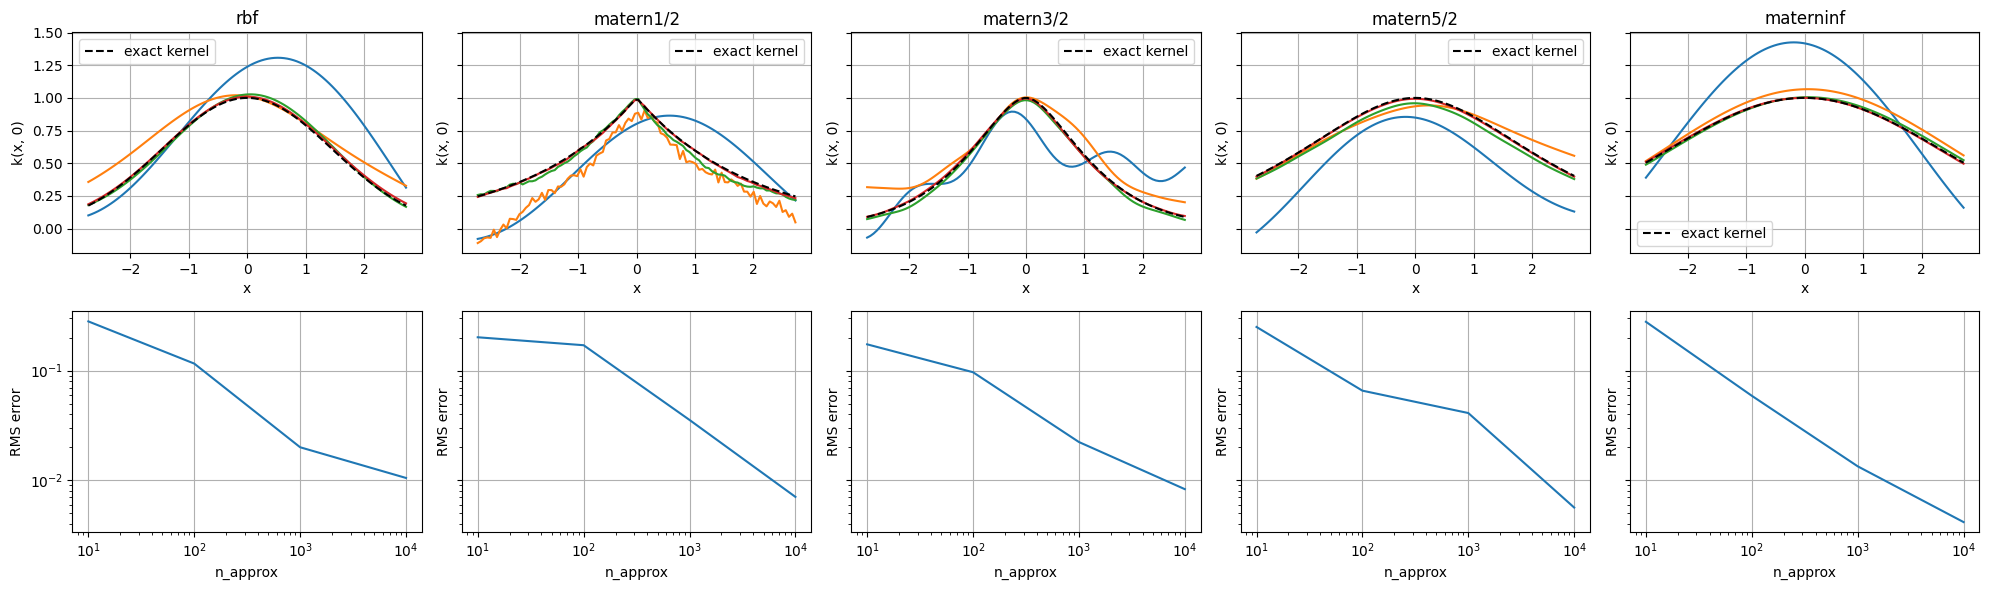

In [5]:
def sample_rbf_spectral_density(length_scale, n_approx=1000, n_dim=1):
    """Spectral density of RBF kernel
    
    given
    .. math ::
        k(x, x')_l = \prod_i \exp(-\frac{1}{2 l_i^2} \|x_i - x'_i \|^2)
    
    the spectral density is
    .. math ::
        p(w) = \prod_i \exp(-\frac{1}{2} \|x_1 - x_2 \|^2)
    
    where w is the frequency, and d is the number of dimensions.
    """
    # Sample normal distributions
    if not isinstance(length_scale, np.ndarray) or length_scale.shape[0] != 1:
        length_scale = np.ones(n_dim) * length_scale
    scale = 1 / np.ones_like(length_scale)# (2 * np.pi * length_scale)
    # since the dimensions are independent, we can sample them separately
    w = RANDOM_STATE.normal(loc=np.zeros_like(length_scale), scale=scale, size=(n_approx, n_dim))
    return (w / length_scale).T

def sample_exp_spectral_density(length_scale, n_approx=1000, n_dim=1):
    """Spectral density of laplacian kernel
    
    given
    .. math ::
        k(x, x')_l = \prod_i \exp(-\frac{1}{l_i} \|x_i - x'_i \|)
    
    the normalized spectral density is a cauchy distribution, as described in
    the paper "Random Features for Large-Scale Kernel Machines" by Rahimi and Recht.
    .. math ::
        p(w) = \prod_i \frac{1}{\pi l_i (1 + \|w_i\|^2/l_i^2)}

    where w is the frequency, and d is the number of dimensions.

    Reference:
    Rahimi, A., & Recht, B. (2008). Random features for large-scale kernel machines.

    Parameters
    ----------
    """
    # Sample exponential distributions
    if not isinstance(length_scale, np.ndarray) or length_scale.shape[0] != 1:
        length_scale = np.ones(n_dim) * length_scale
    # since the dimensions are independent, we can sample them separately
    w = 1/length_scale * RANDOM_STATE.standard_cauchy(size=(n_dim, n_approx))
    return w

def sample_matern32_spectral_density(length_scale, n_approx=1000, n_dim=1):
    """Spectral density of Matern kernel with nu=3/2

    given
    .. math ::
        k(x, x')_l = \prod_i (1 + \sqrt{3} \|x_i - x'_i \| / l_i) \exp(-\sqrt{3} \|x_i - x'_i \| / l_i)

    the normalized spectral density is a location-scale t-distribution with 3 degrees of freedom

    .. math ::
        S(w) \propto \prod_i 1/(\lambda_i^2 + w_i^2)^{2}
    
    with lambda_i = sqrt(3) / l_i

    Parameters
    ----------
    length_scale : float
        The length scale of the kernel
    
    n_approx : int
        The number of samples to draw from the spectral density
    
    n_dim : int
        The number of dimensions of the kernel

    Returns
    -------
    w : np.ndarray
        The samples from the spectral density
    """
    if not isinstance(length_scale, np.ndarray) or length_scale.shape[0] != 1:
        length_scale = np.ones(n_dim) * length_scale
    w = 1 / length_scale * RANDOM_STATE.standard_t(df=3, size=(n_dim, n_approx))
    return w

def sample_matern52_spectral_density(length_scale, n_approx=1000, n_dim=1):
    """Spectral density of Matern kernel with nu=5/2

    given
    .. math ::
        k(x, x')_l = \prod_i (1 + \sqrt{3} \|x_i - x'_i \| / l_i) \exp(-\sqrt{3} \|x_i - x'_i \| / l_i)

    the normalized spectral density is a location-scale t-distribution with 5 degrees of freedom

    .. math ::
        S(w) \propto \prod_i 1/(\lambda_i^2 + w_i^2)^{3}
    
    with lambda_i = sqrt(5) / l_i

    Parameters
    ----------
    length_scale : float
        The length scale of the kernel
    
    n_approx : int
        The number of samples to draw from the spectral density
    
    n_dim : int
        The number of dimensions of the kernel

    Returns
    -------
    w : np.ndarray
        The samples from the spectral density
    """
    if not isinstance(length_scale, np.ndarray) or length_scale.shape[0] != 1:
        length_scale = np.ones(n_dim) * length_scale
    w = 1 / length_scale * RANDOM_STATE.standard_t(df=5, size=(n_dim, n_approx))
    return w

def sample_matern_spectral_density(length_scale, nu, n_approx=1000, n_dim=1):
    # https://arxiv.org/pdf/1611.06740
    if nu == np.inf:
        return sample_rbf_spectral_density(length_scale, n_approx, n_dim)
    elif nu == 0.5:
        return sample_exp_spectral_density(length_scale, n_approx, n_dim)
    elif nu == 1.5:
        return sample_matern32_spectral_density(length_scale, n_approx, n_dim)
    elif nu == 2.5:
        return sample_matern52_spectral_density(length_scale, n_approx, n_dim)
    else:
        msg = (
            "Spectral density for Matern kernel only available for nu=0.5, 1.5, 2.5, and inf"
            f" but got nu={nu}."
        )
        raise ValueError(msg)
    pass


def sample_b(size):
    return RANDOM_STATE.uniform(0, 2*np.pi, size=size)


def feature_map(x, w, b):
    """Feature map of the random Fourier features
    
    given
    .. math ::
        z(x) = \sqrt{2/d} \cos(w^T x + b)
        
        where w is the frequency, and b is the bias, the feature map is
        .. math ::
            \phi(x) = z(x) = \sqrt{2/d} \cos(w^T x + b)
            
    Parameters
    ----------
    x : np.ndarray
        The input data
        
    w : np.ndarray
        The frequency of the random features
        
    b : np.ndarray
        The bias of the random features
    
    Returns
    -------
    phi : np.ndarray
        The feature map of the random Fourier features
    """
    phi = np.cos(x @ w + b)
    return np.sqrt(2 / w.shape[1]) * phi

def sample_features(kernel, n_approx=1000):
    if isinstance(kernel, Matern):
        w = sample_matern_spectral_density(
            kernel.get_params()['length_scale'],
            kernel.get_params()['nu'],
            n_approx=n_approx,
            n_dim=kernel.n_dims
        )
    elif isinstance(kernel, RBF):
        w = sample_rbf_spectral_density(
            kernel.get_params()['length_scale'],
            n_approx=n_approx,
            n_dim=kernel.n_dims
        )
    else:
        raise ValueError(f"Kernel {type(kernel)} not supported")
    b = np.expand_dims(sample_b(n_approx), 0)
    return w, b

def approx_kernel(x1, x2, n_approx=1000):
    if len(x1.shape) != 2:
        msg = (f"Expected 2D array, got {x1.shape} array instead:\n"
            "Reshape your data either using array.reshape(-1, 1) if your data has a "
            "single feature or array.reshape(1, -1) if it contains a single sample."
        )
        raise ValueError(msg)

    if len(x2.shape) != 2:
        msg = (f"Expected 2D array, got {x2.shape} array instead:\n"
            "Reshape your data either using array.reshape(-1, 1) if your data has a "
            "single feature or array.reshape(1, -1) if it contains a single sample."
        )
        raise ValueError(msg)
    w, b = sample_features(kernel, n_approx)

    q = feature_map(x1, w, b) @ feature_map(x2, w, b).T
    return np.squeeze(q, axis=1)


LENGTH_SCALE_UPPER_BOUND = 3
LENGTH_LOWER_UPPER_BOUND = 0.1
random_length_scale = lambda: RANDOM_STATE.rand() * (LENGTH_SCALE_UPPER_BOUND - LENGTH_LOWER_UPPER_BOUND) + LENGTH_LOWER_UPPER_BOUND
kernels = {
    'rbf': RBF(length_scale=random_length_scale()),
    'matern1/2': Matern(length_scale=random_length_scale(), nu=1/2),
    'matern3/2': Matern(length_scale=random_length_scale(), nu=3/2),
    'matern5/2': Matern(length_scale=random_length_scale(), nu=5/2),
    'materninf': Matern(length_scale=random_length_scale(), nu=np.inf),
}

fig, axs = plt.subplots(2, 5, figsize=(20, 6), sharey='row')
for i, (name, kernel) in enumerate(kernels.items()):
    rms_error = []
    k_ = kernel(x_forplot.reshape(-1, 1), np.zeros((1, 1))).squeeze()
    for n_approx in all_n_approx:
        approx = approx_kernel(x_forplot.reshape(-1, 1), np.zeros((1, 1)), n_approx)
        axs[0, i].plot(x_forplot, approx)
        rms_error.append(np.sqrt(np.mean((k_ - approx)**2)))
    
    axs[0, i].plot(x_forplot, k_, 'k--', label='exact kernel')
    axs[0, i].set_title(name)
    axs[0, i].set_xlabel('x')
    axs[0, i].set_ylabel('k(x, 0)')
    axs[0, i].grid(True)
    axs[0, i].legend(loc='best')

    axs[1, i].plot(all_n_approx, rms_error)
    axs[1, i].grid(True)
    axs[1, i].set_xlabel('n_approx')
    axs[1, i].set_ylabel('RMS error')
    axs[1, i].set_xscale('log')
    axs[1, i].set_yscale('log')
plt.tight_layout()

In [6]:
def sample_posterior(x, y, w, b, sigma=0.1, n_samples=10):
    # as in M. W. Seeger: Bayesian inference and optimal design for the sparse linear model
    # Appendix B.2 (the degenerate case)

    if n_approx <= x.shape[0]:
        raise ValueError(f"Number of random features {n_approx} must be greater than number of data points {x.shape[0]}")
    phi = feature_map(x, w, b)
    
    Pi_inv = np.diag(np.ones(phi.shape[1]) * 1/sigma**2)
    Q = np.eye(phi.shape[0]) + phi @ Pi_inv @ phi.T
    eig_values, eig_vectors = np.linalg.eig(Q) # D, U, since Q is symmetric => U @ U.T = I

    R = np.diag(1/(np.sqrt(eig_values) * (1 + np.sqrt(eig_values))))

    n = RANDOM_STATE.normal(size=(phi.shape[1], n_samples))
    c = (np.eye(phi.shape[1]) - Pi_inv @ phi.T @ eig_vectors @ R @ eig_vectors.T @ phi) @ np.sqrt(Pi_inv)

    A = phi.T @ phi + sigma**2 * np.eye(phi.shape[1])
    h = np.expand_dims(np.linalg.solve(A, phi.T @ y), 1)
    return sigma * c @ n + h


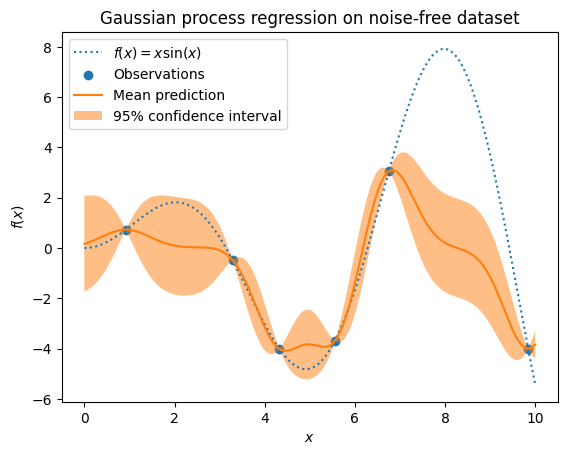

In [7]:


X = np.linspace(start=0, stop=10, num=512).reshape(-1, 1)
y = np.squeeze(X * np.sin(X))

rng = np.random.RandomState(1)
training_indices = rng.choice(np.arange(y.size), size=6, replace=False)
X_train, y_train = X[training_indices], y[training_indices]


kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gaussian_process.fit(X_train, y_train)
gaussian_process.kernel_

mean_prediction, std_prediction = gaussian_process.predict(X, return_std=True)

plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.scatter(X_train, y_train, label="Observations")
plt.plot(X, mean_prediction, label="Mean prediction")
plt.fill_between(
    X.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Gaussian process regression on noise-free dataset")

ylims = plt.ylim()


(-6.108051446972817, 8.584435990767808)

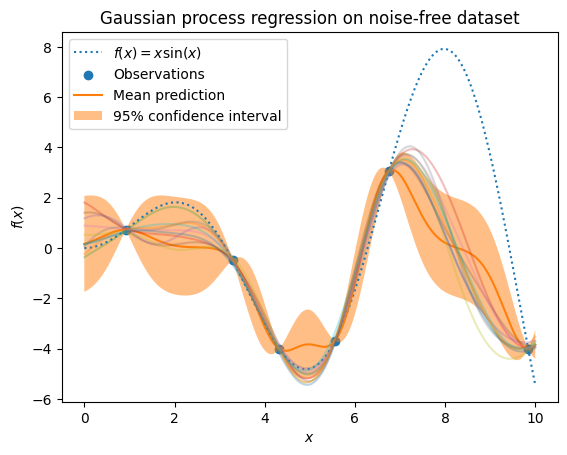

In [9]:
plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.scatter(X_train, y_train, label="Observations")
plt.plot(X, mean_prediction, label="Mean prediction")
plt.fill_between(
    X.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Gaussian process regression on noise-free dataset")

w, b = sample_features(kernel, n_approx=10000)
theta = sample_posterior(X_train, y_train, w, b, n_samples=10, sigma=0.1)
samples = feature_map(X, w, b) @ theta
plt.plot(X, samples, alpha=0.3)


#samples_ = gaussian_process.sample_y(X, n_samples=10)
#plt.plot(X, samples_, 'k--', alpha=0.3)

plt.ylim(ylims)

